# (09) Ablation -- neural, plot

**Motivation**: Lesion bottom-up and top-down pathways, test how much performance drops. Plot performance and alignment changes (overall, and also per neuron). <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Setup

In [2]:
fig_dir = pjoin(fig_base_dir, 'rebuttal_aug')
print(fig_dir)

path = '/home/hadi/Dropbox/git/jb-MTMST/tmp/neural_analysis'

/home/hadi/Dropbox/git/jb-MTMST/figs/rebuttal_aug

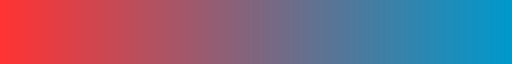

In [3]:
_PROPS = {
    'meanprops': {
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'k',
        'markersize': 3,
        'alpha': 1.0},
    'flierprops': {
        'marker': 'o',
        'markersize': 1.5,
        'alpha': 0.3,
        'zorder': 1},
    'showfliers': True,
    'showmeans': True,
    'dodge': True,
    'width': 0.7,
}
pal_lesion = {
    'enc': '#FF3333',
    'dec': '#0099CC',
}
make_cmap([
    to_rgb(c) for c in
    pal_lesion.values()
], show=False)

## Load

In [4]:
fits = {
    'none-none': 'fixate1_nf-420_beta-0.15_(2023_08_08,03:01)',
    'enc-2': 'fixate1_nf-420_beta-0.15_lesion-enc-2_(2023_08_07,22:05)',
    'enc-4': 'fixate1_nf-420_beta-0.15_lesion-enc-4_(2023_08_07,23:00)',
    'enc-8': 'fixate1_nf-420_beta-0.15_lesion-enc-8_(2023_08_07,23:48)',
    'dec-2': 'fixate1_nf-420_beta-0.15_lesion-dec-2_(2023_08_08,00:38)',
    'dec-4': 'fixate1_nf-420_beta-0.15_lesion-dec-4_(2023_08_08,01:26)',
    'dec-8': 'fixate1_nf-420_beta-0.15_lesion-dec-8_(2023_08_08,02:13)',
}

### Load df (perf)

In [5]:
df_true = summarize_neural_fits(fits['none-none'])[0]
df_lesion = pd.concat([
    summarize_neural_fits(f)[0]
    for k, f in fits.items()
    if 'lesion' in f
])

### Load (make df_align)

In [6]:
df_align = []
for k, v in fits.items():
    try:
        f = next(
            f for f in
            os.listdir(path)
            if v in f
        )
        x = np.load(
            file=pjoin(path, f),
            allow_pickle=True,
        ).item()
        align_dict = {
            cell: 1 - entropy_normalized(p / p.sum())
            for cell, p in x['perm_mu'].items()
        }
        for _k, a in align_dict.items():
            _, expt, cell = _k.split('_')
            lesion, lesion_scale = k.split('-')
            try:
                lesion_scale = int(lesion_scale)
            except ValueError:
                pass
            df_align.append({
                'expt': [expt],
                'cell': [int(cell)],
                'lesion': [lesion],
                'lesion_scale': [lesion_scale],
                'align': [a],
            })
    except StopIteration:
        pass

df_align = pd.DataFrame(merge_dicts(df_align))

### Make d2p (perf)

In [7]:
d2p_perf = []
for i, r in df_true.iterrows():
    expt, cell = r['expt'], r['cell']
    _df = df_lesion.loc[
        (df_lesion['expt'] == expt) &
        (df_lesion['cell'] == cell)
    ]
    d = {
        k: _df[k].values for k in [
            'expt', 'cell', 'lesion',
            'lesion_scale', 'perf',
        ]}
    d['delta_perf'] = 100 * (_df['perf'] - r['perf']) / r['perf']
    d2p_perf.append(d)
d2p_perf = pd.DataFrame(merge_dicts(d2p_perf))

### Make d2p (align)

In [8]:
d2p_align = []
for i, r in df_true.iterrows():
    expt, cell = r['expt'], r['cell']
    align_true = df_align.loc[
        (df_align['expt'] == expt) &
        (df_align['cell'] == cell) &
        (df_align['lesion'] == 'none') &
        (df_align['lesion_scale'] == 'none'),
        'align',
    ].item()
    for les in ['enc', 'dec']:
        for les_s in [2, 4, 8]:
            try:
                align = df_align.loc[
                    (df_align['expt'] == expt) &
                    (df_align['cell'] == cell) &
                    (df_align['lesion'] == les) &
                    (df_align['lesion_scale'] == les_s),
                    'align',
                ].item()
            except ValueError:
                continue
            delta_align = 100 * (align - align_true) / align_true
            d2p_align.append({
                'lesion': [les],
                'lesion_scale': [les_s],
                'delta_align': [delta_align],
            })
d2p_align = pd.DataFrame(merge_dicts(d2p_align))

## Plot

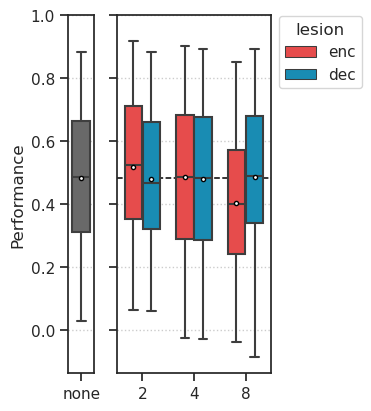

In [9]:
fig, axes = create_figure(1, 2, (3.6, 4), sharey='all', layout='constrained', width_ratios=[0.17, 1])

sns.boxplot(
    data=df_true,
    x='lesion_scale',
    y='perf',
    hue='lesion',
    palette={'none': 'dimgrey'},
    ax=axes[0],
    **_PROPS,
)
sns.boxplot(
    data=df_lesion,
    x='lesion_scale',
    y='perf',
    hue='lesion',
    palette=pal_lesion,
    ax=axes[1],
    **_PROPS,
)
move_legend(axes[0])
move_legend(axes[1], (1, 1.02))

axes[1].axhline(df_true['perf'].mean(), ls='--', color='k', lw=1.1, zorder=0)

axes[0].set(xlabel='', ylabel='Performance', ylim=(None, 1.0))
axes[1].set(xlabel='', ylabel='')

axes[0].grid(axis='y')
axes[1].grid(axis='y')

plt.show()

In [10]:
df_true['perf'].mean()

0.48468850124798635

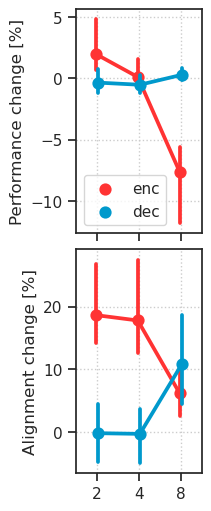

In [11]:
fig, axes = create_figure(2, 1, (2, 5), 'all', layout='constrained')

sns.pointplot(
    data=d2p_perf,
    x='lesion_scale',
    y='delta_perf',
    hue='lesion',
    palette=pal_lesion,
    estimator='median',
    dodge=True,
    ax=axes[0],
)
sns.pointplot(
    data=d2p_align,
    x='lesion_scale',
    y='delta_align',
    hue='lesion',
    palette=pal_lesion,
    estimator='median',
    dodge=True,
    ax=axes[1],
)
axes[0].set(xlabel='', ylabel='Performance change [%]')
axes[1].set(xlabel='', ylabel='Alignment change [%]')

sns.move_legend(axes[0], loc='best', title='')
move_legend(axes[1])

for ax in axes.flat:
    # ax.axhline(0, color='k', ls='--', zorder=0)
    ax.grid()
plt.show()

## $\beta = 0.5$

### Load

In [12]:
fits = {
    'none-none': 'fixate1_nf-420_beta-0.5_(2023_08_08,15:39)',
    'enc-2': 'fixate1_nf-420_beta-0.5_lesion-enc-2_(2023_08_08,08:07)',
    'enc-4': 'fixate1_nf-420_beta-0.5_lesion-enc-4_(2023_08_08,09:09)',
    'enc-8': 'fixate1_nf-420_beta-0.5_lesion-enc-8_(2023_08_08,11:24)',
    'dec-2': 'fixate1_nf-420_beta-0.5_lesion-dec-2_(2023_08_08,12:30)',
    'dec-4': 'fixate1_nf-420_beta-0.5_lesion-dec-4_(2023_08_08,13:32)',
    'dec-8': 'fixate1_nf-420_beta-0.5_lesion-dec-8_(2023_08_08,14:35)',
}

#### Load df (perf)

In [13]:
df_true = summarize_neural_fits(fits['none-none'])[0]
df_lesion = pd.concat([
    summarize_neural_fits(f)[0]
    for k, f in fits.items()
    if 'lesion' in f
])

#### Load (make df_align)

In [14]:
df_align = []
for k, v in fits.items():
    try:
        f = next(
            f for f in
            os.listdir(path)
            if v in f
        )
        x = np.load(
            file=pjoin(path, f),
            allow_pickle=True,
        ).item()
        align_dict = {
            cell: 1 - entropy_normalized(p / p.sum())
            for cell, p in x['perm_mu'].items()
        }
        for _k, a in align_dict.items():
            _, expt, cell = _k.split('_')
            lesion, lesion_scale = k.split('-')
            try:
                lesion_scale = int(lesion_scale)
            except ValueError:
                pass
            df_align.append({
                'expt': [expt],
                'cell': [int(cell)],
                'lesion': [lesion],
                'lesion_scale': [lesion_scale],
                'align': [a],
            })
    except StopIteration:
        pass

df_align = pd.DataFrame(merge_dicts(df_align))

#### Make d2p (perf)

In [15]:
d2p_perf = []
for i, r in df_true.iterrows():
    expt, cell = r['expt'], r['cell']
    _df = df_lesion.loc[
        (df_lesion['expt'] == expt) &
        (df_lesion['cell'] == cell)
    ]
    d = {
        k: _df[k].values for k in [
            'expt', 'cell', 'lesion',
            'lesion_scale', 'perf',
        ]}
    d['delta_perf'] = 100 * (_df['perf'] - r['perf']) / r['perf']
    d2p_perf.append(d)
d2p_perf = pd.DataFrame(merge_dicts(d2p_perf))

#### Make d2p (align)

In [16]:
d2p_align = []
for i, r in df_true.iterrows():
    expt, cell = r['expt'], r['cell']
    align_true = df_align.loc[
        (df_align['expt'] == expt) &
        (df_align['cell'] == cell) &
        (df_align['lesion'] == 'none') &
        (df_align['lesion_scale'] == 'none'),
        'align',
    ].item()
    for les in ['enc', 'dec']:
        for les_s in [2, 4, 8]:
            try:
                align = df_align.loc[
                    (df_align['expt'] == expt) &
                    (df_align['cell'] == cell) &
                    (df_align['lesion'] == les) &
                    (df_align['lesion_scale'] == les_s),
                    'align',
                ].item()
            except ValueError:
                continue
            delta_align = 100 * (align - align_true) / align_true
            d2p_align.append({
                'lesion': [les],
                'lesion_scale': [les_s],
                'delta_align': [delta_align],
            })
d2p_align = pd.DataFrame(merge_dicts(d2p_align))

### Plot

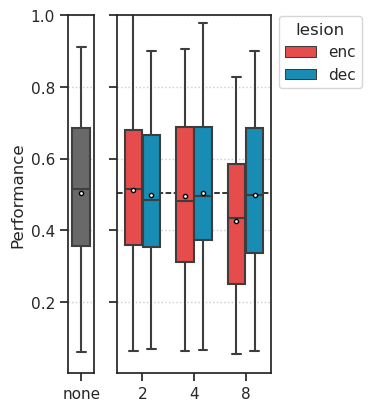

In [17]:
fig, axes = create_figure(1, 2, (3.6, 4), sharey='all', layout='constrained', width_ratios=[0.17, 1])

sns.boxplot(
    data=df_true,
    x='lesion_scale',
    y='perf',
    hue='lesion',
    palette={'none': 'dimgrey'},
    ax=axes[0],
    **_PROPS,
)
sns.boxplot(
    data=df_lesion,
    x='lesion_scale',
    y='perf',
    hue='lesion',
    palette=pal_lesion,
    ax=axes[1],
    **_PROPS,
)
move_legend(axes[0])
move_legend(axes[1], (1, 1.02))

axes[1].axhline(df_true['perf'].mean(), ls='--', color='k', lw=1.1, zorder=0)

axes[0].set(xlabel='', ylabel='Performance', ylim=(None, 1.0))
axes[1].set(xlabel='', ylabel='')

axes[0].grid(axis='y')
axes[1].grid(axis='y')

plt.show()

In [18]:
df_true['perf'].mean()

0.5036785932719765

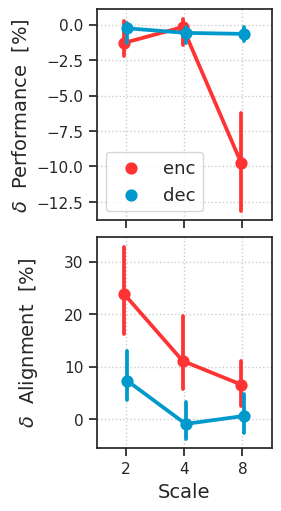

In [39]:
fig, axes = create_figure(2, 1, (2.7, 5), 'all', layout='constrained')

sns.pointplot(
    data=d2p_perf,
    x='lesion_scale',
    y='delta_perf',
    hue='lesion',
    palette=pal_lesion,
    estimator='median',
    dodge=True,
    ax=axes[0],
)
sns.pointplot(
    data=d2p_align,
    x='lesion_scale',
    y='delta_align',
    hue='lesion',
    palette=pal_lesion,
    estimator='median',
    dodge=True,
    ax=axes[1],
)
axes[0].set(xlabel='')
axes[1].set_xlabel('Scale', fontsize=14)

axes[0].set_ylabel(r"$\delta$" + '  Performance  ' + r"$\left[\%\right]$", fontsize=14)
axes[1].set_ylabel(r"$\delta$" + '  Alignment  ' + r"$\left[\%\right]$", fontsize=14, labelpad=17)

sns.move_legend(axes[0], loc='best', title='', fontsize=13)
move_legend(axes[1])

for ax in axes.flat:
    # ax.axhline(0, color='k', ls='--', zorder=0)
    ax.grid()
fig.savefig(pjoin(fig_dir, 'lesion_neural.pdf'), bbox_inches='tight')
plt.show()

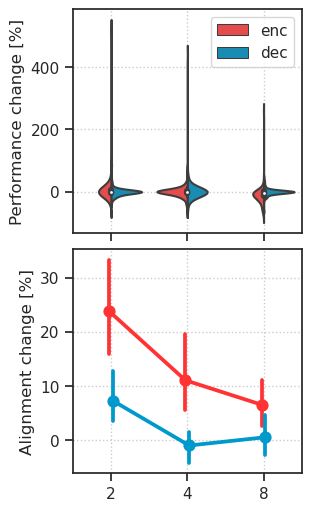

In [23]:
fig, axes = create_figure(2, 1, (3, 5), 'all', layout='constrained')

sns.violinplot(
    data=d2p_perf,
    x='lesion_scale',
    y='delta_perf',
    hue='lesion',
    palette=pal_lesion,
    estimator='median',
    split=True,
    dodge=True,
    ax=axes[0],
)
sns.pointplot(
    data=d2p_align,
    x='lesion_scale',
    y='delta_align',
    hue='lesion',
    palette=pal_lesion,
    estimator='median',
    dodge=True,
    ax=axes[1],
)
axes[0].set(xlabel='', ylabel='Performance change [%]')
axes[1].set(xlabel='', ylabel='Alignment change [%]')

sns.move_legend(axes[0], loc='best', title='')
move_legend(axes[1])

for ax in axes.flat:
    # ax.axhline(0, color='k', ls='--', zorder=0)
    ax.grid()
# fig.savefig(pjoin(fig_dir, 'lesion_neural.pdf'), bbox_inches='tight')
plt.show()